In [1]:
import os
import pandas as pd

names_df = pd.DataFrame(os.listdir("./data/pokemon_images/images"), columns=["Name"])
names_df["Path"] = "./data/pokemon_images/images/" + names_df["Name"]
names_df["Name"] = names_df["Name"].str.split(".").str[0]
display(names_df)

health_stats = pd.read_csv("./data/pokemon_with_stats/Pokemon.csv")
health_stats["Name"] = health_stats["Name"].str.lower()
health_stats = health_stats.drop(
    ["#", "Type 1", "Type 2", "Total", "Generation", "Legendary"], axis=1
)
display(health_stats)

merged = names_df.merge(health_stats, on=["Name"], how="inner")

merged

,Name,Path
0,staraptor,./data/pokemon_images/images/staraptor.npz
1,parasect,./data/pokemon_images/images/parasect.png
2,lumineon,./data/pokemon_images/images/lumineon.png
3,pidove,./data/pokemon_images/images/pidove.npz
4,raikou,./data/pokemon_images/images/raikou.png
...,...,...
1502,latios,./data/pokemon_images/images/latios.png
1503,gligar,./data/pokemon_images/images/gligar.npz
1504,mew,./data/pokemon_images/images/mew.png
1505,ekans,./data/pokemon_images/images/ekans.png


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,bulbasaur,45,49,49,65,65,45
1,ivysaur,60,62,63,80,80,60
2,venusaur,80,82,83,100,100,80
3,venusaurmega venusaur,80,100,123,122,120,80
4,charmander,39,52,43,60,50,65
...,...,...,...,...,...,...,...
795,diancie,50,100,150,100,150,50
796,dianciemega diancie,50,160,110,160,110,110
797,hoopahoopa confined,80,110,60,150,130,70
798,hoopahoopa unbound,80,160,60,170,130,80


,Name,Path,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,staraptor,./data/pokemon_images/images/staraptor.npz,85,120,70,50,60,100
1,parasect,./data/pokemon_images/images/parasect.png,60,95,80,60,80,30
2,lumineon,./data/pokemon_images/images/lumineon.png,69,69,76,69,86,91
3,pidove,./data/pokemon_images/images/pidove.npz,50,55,50,36,30,43
4,raikou,./data/pokemon_images/images/raikou.png,90,85,75,115,100,115
...,...,...,...,...,...,...,...,...
1391,floatzel,./data/pokemon_images/images/floatzel.png,85,105,55,85,50,115
1392,latios,./data/pokemon_images/images/latios.png,80,90,80,130,110,110
1393,gligar,./data/pokemon_images/images/gligar.npz,65,75,105,35,65,85
1394,mew,./data/pokemon_images/images/mew.png,100,100,100,100,100,100


In [2]:
import numpy as np
import cv2

npz_paths = []
for i, row in merged.iterrows():
    picture_path = row["Path"]

    npz_path = picture_path.replace(".png", ".npz")
    npz_paths.append(npz_path)
    if not os.path.exists(npz_path):
        pic_bgr_arr = cv2.imread(picture_path)
        pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)

        atk, deff = row["Attack"], row["Defense"]
        spatk, spdef, spd = row["Sp. Atk"], row["Sp. Def"], row["Speed"]
        stats = np.array([atk, deff, spatk, spdef, spd])

        hp = row["HP"]
        np.savez_compressed(npz_path, pic=pic_rgb_arr, stats=stats, hp=hp)

merged["NPZ_Path"] = pd.Series(npz_paths)

stats_df = merged.select_dtypes("number").drop("HP", axis=1)

means = stats_df.mean().values
std_devs = stats_df.std().values

In [3]:
import tensorflow as tf

def stat_scaler(tensor):
    return (tensor - means) / std_devs

stat_scaler(tf.constant([2, 3, 4, 5, 6]))

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-2.57142857, -2.31034483, -2.28571429, -2.42307692, -2.18518519])>

,Name,HP,NPZ_Path
147,serperior,75,./data/pokemon_images/images/serperior.npz
122,crawdaunt,63,./data/pokemon_images/images/crawdaunt.npz
1372,bergmite,55,./data/pokemon_images/images/bergmite.npz
1353,jumpluff,75,./data/pokemon_images/images/jumpluff.npz
375,noibat,40,./data/pokemon_images/images/noibat.npz
...,...,...,...
1006,vanilluxe,71,./data/pokemon_images/images/vanilluxe.npz
727,paras,35,./data/pokemon_images/images/paras.npz
249,ditto,48,./data/pokemon_images/images/ditto.npz
761,ralts,28,./data/pokemon_images/images/ralts.npz


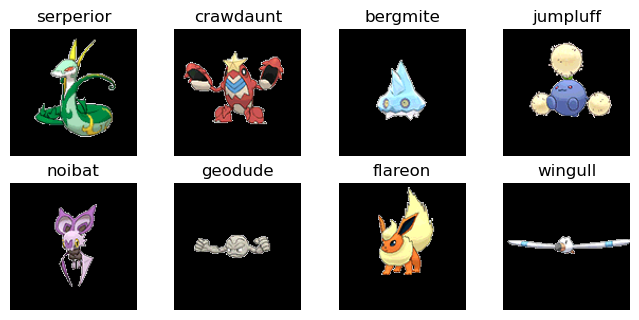

In [4]:
import matplotlib.pyplot as plt

# we can drop all data in the df that exists in the npz
drop_cols = ["Path", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
merged_clean = merged.drop(drop_cols, axis=1)
shuffled_df = merged_clean.sample(frac=1)

train_idx, val_idx = 500, 600
train_df, val_df, test_df = (
    shuffled_df.iloc[:train_idx],
    shuffled_df.iloc[train_idx:val_idx],
    shuffled_df.iloc[val_idx:],
)

display(train_df)
plt.figure(figsize=(8, 8))
for idx, (npz_path, title) in enumerate(
    zip(train_df["NPZ_Path"].values[:8], train_df["Name"].values[:8])
):  # Adjust 'Name' to the actual column name for titles
    pkmon_npz = np.load(npz_path)
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(pkmon_npz["pic"])
    plt.axis("off")
    plt.title(title)
    ax.set_facecolor("white")

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

In [5]:
def get_x_y(df):
    x_pic, x_stats = [], []
    y = []

    for name in df["NPZ_Path"]:
        loaded_npz = np.load(name)
        pic, stats, hp = loaded_npz["pic"], loaded_npz["stats"], loaded_npz["hp"]

        x_pic.append(pic)
        x_stats.append(stats)
        y.append(hp)

    x_pic, x_stats = np.array(x_pic), np.array(x_stats)
    y = np.array(y)

    return (x_pic, x_stats), y


(x_train_pic, x_train_stats), y_train = get_x_y(train_df)
(x_val_pic, x_val_stats), y_val = get_x_y(val_df)
(x_test_pic, x_test_stats), y_test = get_x_y(test_df)

print("train:", (x_train_pic.shape, x_train_stats.shape), y_train.shape)
print("val:", (x_val_pic.shape, x_val_stats.shape), y_val.shape)
print("test:", (x_test_pic.shape, x_test_stats.shape), y_test.shape)

train: ((500, 120, 120, 3), (500, 5)) (500,)
val: ((100, 120, 120, 3), (100, 5)) (100,)
test: ((796, 120, 120, 3), (796, 5)) (796,)


In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# Define picture CNN stream
input_pic = layers.Input(shape=x_train_pic[0].shape, name="input_pic")
x = layers.Lambda(preprocess_input)(input_pic)
x = MobileNetV2(input_shape=x_train_pic[0].shape, include_top=False)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(10, activation="relu")(x)
x = Model(inputs=input_pic, outputs=x)

# Define stats (feed-forward) stream
input_stats = layers.Input(shape=x_train_stats[0].shape, name="input_stats")
y = layers.Lambda(stat_scaler)(input_stats)
y = layers.Dense(32, activation="relu")(y)
y = layers.Dense(10, activation="relu")(y)
y = Model(inputs=input_stats, outputs=y)

# Concat layers
combined = layers.concatenate([x.output, y.output])

z = layers.Dense(4, activation="relu")(combined)
z = layers.Dense(1, activation="linear")(z)

model = Model(inputs=[x.input, y.input], outputs=z)

/var/folders/0c/jrnrvt7101j2y7lhwylk7lv40000gn/T/ipykernel_20943/311464961.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  x = MobileNetV2(input_shape=x_train_pic[0].shape, include_top=False)(x)


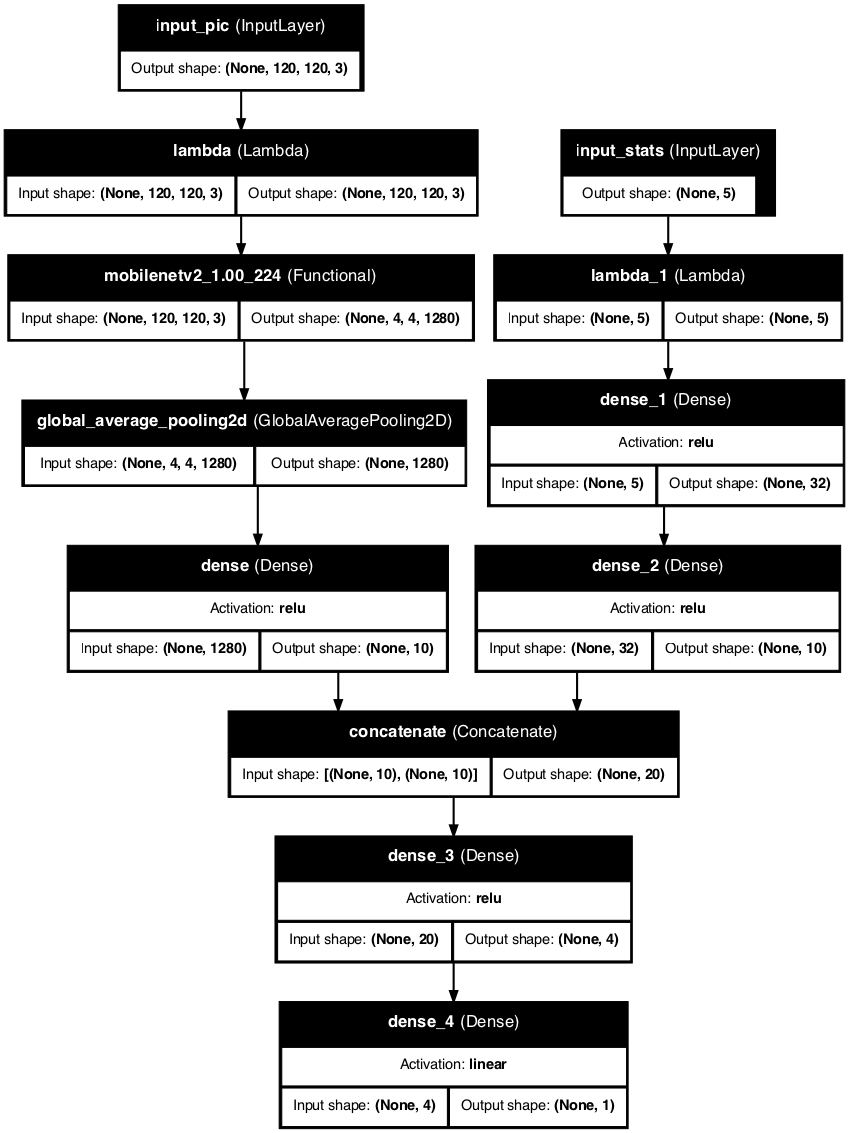

In [7]:
display(
    keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=False,
        dpi=75,
        expand_nested=False,
        # rankdir="LR",
        show_dtype=False,
        show_layer_names=True,
    )
)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer, metrics=["mean_absolute_error"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="mean_absolute_error", min_delta=5, patience=5
    ),
    keras.callbacks.TensorBoard(
    log_dir="/Users/giacomoaris/Documents/deep-learning-intro-course/sample_projects/pokemon/logs",
)]

model.fit(
    x=[x_train_pic, x_train_stats],
    y=y_train,
    validation_data=([x_val_pic, x_val_stats], y_val),
    epochs=10,
    callbacks=[callbacks_list],
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - loss: 306.5009 - mean_absolute_error: 11.8411 - val_loss: 453.1868 - val_mean_absolute_error: 17.0188
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 135.5983 - mean_absolute_error: 8.1982 - val_loss: 588.9144 - val_mean_absolute_error: 18.4024
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 206.2742 - mean_absolute_error: 7.3230 - val_loss: 2104.7476 - val_mean_absolute_error: 36.7724


In [9]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_pic           │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 120, 120,  │          0 │ input_pic[0][0]   │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stats         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 4, 4,      │  2,257,984 │ lambda[0][0]      │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 5)         │          0 │ input_stats[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        192 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     12,810 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        330 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │         84 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          5 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,745,993 (25.73 MB)

 Trainable params: 2,237,293 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,474,588 (17.07 MB)